In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


# Open data files
users = pd.read_csv('/datasets/megaline_users.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')

# Study general info on data
print(users.info()) #print(users.head())
print(calls.info()) #print(calls.head())
print(messages.info()) #print(messages.head())
print(internet.info()) #print(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
m

Exploratory Data Analysis: 

The 'users' table contains no duplicate rows and almost all of its columns contain non-null values. Only the 'churn_date' column contains NaN values but this is because the user is still using the calling plan. This table displays 500 customers or the phone company that are either were or currently are subscribed to a phone plan.

The 'plans' table contains no duplicate rows and all of its columns contain non-null values. This table displays the two phone plans to compare against each other and what each of them contains.

The 'calls' table contains no duplicate rows and all of its columns contain non-null values. This table displays all calls that a user made, including the data and duration of the call.

The 'messages' table contains no duplicate rows and all of its columns contain non-null values. This table displays all messages that a user sent, including the date it was sent.

The 'internet' table contains no duplicates and all of its columns contain non-null values. This  table displays all internet sessions, including the dateusrs and the amount of mb used during the session.

In [2]:
# Preprocess tables

# Users table - convert string to datetime object
users['reg_date'] = pd.to_datetime(users['reg_date']).dt.date
users['churn_date'] = pd.to_datetime(users['churn_date']).dt.date

# Rename tariff column to plan for clarity
users = users.rename(columns={'tariff': 'plan'})

# Calls table - convert string to datetime object
calls['call_date'] = pd.to_datetime(calls['call_date']).dt.date

# Add month column for call_date
calls['call_month'] = pd.to_datetime(calls['call_date']).dt.month

# round call duration up to one minute
calls['duration'] = np.ceil(calls['duration'])

# Rename id column to call id for clarity
calls = calls.rename(columns={'id': 'call_id'})

# Messages table - convert string to datetime object
messages['message_date'] = pd.to_datetime(messages['message_date']).dt.date

# Add month column for message_date
messages['message_month'] = pd.to_datetime(messages['message_date']).dt.month

# Rename id column to message id for clarity
messages = messages.rename(columns={'id': 'message_id'})

# Internet table - convert string to datetime object
internet['session_date'] = pd.to_datetime(internet['session_date']).dt.date

# Add month column for session_date
internet['session_month'] = pd.to_datetime(internet['session_date']).dt.month

# round internet session up to one megabyte
internet['mb_used'] = np.ceil(internet['mb_used'])

# Rename id column to internet id for clarity
internet = internet.rename(columns={'id': 'internet_id'})

# Plans table - convert mb_per_month_included to gb_per_month_included for clarity
plans['mb_per_month_included'] = (plans['mb_per_month_included'] / 1024)
plans = plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'})

#print(real_estate['total_images'].unique())
#print(real_estate['total_images'].value_counts())
#print(real_estate['total_images'].isna().sum())

Data Preprocessing:

In the 'users' table, I converted the 'reg_date' column to a DateTime Python object. I renamed the 'tariff' column to the 'plan' column.

In the 'calls' table, I converted the 'call_date' column to a DateTime Python object. I created a 'call_month' column by extracting only the numerical month value from the 'call_date' column. I renamed the 'id' column to 'call_id'. I decided to keep missed calls, whose 'duration' value is 0.0 because these calls won't affect the analysis. I rounded call duration upto a minute.

In the 'messages' table, I converted the 'message_date' column to a DateTime Python object. I created a 'message_month' column by extracting onlythe numerical month value from the 'message_date' column. I renamed the 'id' column to 'message_id'.

In the 'internet' table, I converted the 'session_date' column to a DateTime Python object. I created a 'session_month'column by extracting only the numerical month valuefrom the 'session_date' column. I renamed the 'id' column to 'internet_id'. I rounded internet session up to one megabyte. 

In the 'plans' table, I converted the 'mb_per_month_included' column from megabytes to gigabytes by dividing by 1024. I renamed this column to 'gb_per_month_included'. 

In [3]:
# Additional preprocessing regarding serivce date vs churn data

# get the rows who have a non null churn date
userIdChurn = users[~users['churn_date'].isnull()]
userIdChurn = userIdChurn[['user_id','churn_date']]

# for every non-null churn date row
for index, row in userIdChurn.iterrows():
    user_id = row['user_id']
    churn_date = row['churn_date']
    
    calls.drop(calls.index[(calls['user_id'] == user_id) &(calls['call_date'] > churn_date)], inplace=True)
    messages.drop(messages.index[(messages['user_id'] == user_id) &(messages['message_date'] > churn_date)], inplace=True)
    internet.drop(internet.index[(internet['user_id'] == user_id) &(internet['session_date'] > churn_date)], inplace=True)


In the data, there are some irregularities where a client has entries for calls/messages/internet sessions passed their churn data (date they stopped using the service). For these cases, I will assume that this is a mistake and these rows are removed. 

I sliced the 'users' table for users who have a non-null churn date and extracted their user_id / churn_date. For every user who has a non-null churn date, I looked at the calls, messages, internet tables for their entries and I dropped any row in these tables with a matching user_id and whose call/message/session_date is greater than their churn date. 

In [4]:
# For each user, find the number of calls made and minutes used per month
userCalls = pd.pivot_table(calls, values='duration', index=['user_id', 'call_month'], aggfunc=['count','sum'])
userCalls.columns = ['calls_made','minutes_used_per_month']
userCalls['minutes_used_per_month'] = np.ceil(userCalls['minutes_used_per_month'])
userCalls.reset_index(inplace=True)
display(userCalls)

# For each user, find the number of text messages sent per month
userMessages = pd.pivot_table(messages, values='message_id', index=['user_id', 'message_month'], aggfunc=['count'])
userMessages.columns = ['messages_sent_per_month']
userMessages.reset_index(inplace=True)
display(userMessages)

# For each user, find the volume of data per month
userInternet = pd.pivot_table(internet, values='mb_used', index=['user_id', 'session_month'], aggfunc=['sum'])
userInternet.columns = ['gb_used_per_month']
userInternet['gb_used_per_month'] = np.ceil(userInternet['gb_used_per_month'] / 1024)
userInternet.reset_index(inplace=True)
display(userInternet)

,user_id,call_month,calls_made,minutes_used_per_month
0,1000,12,16,124.0
1,1001,8,27,182.0
2,1001,9,49,315.0
3,1001,10,65,393.0
4,1001,11,64,426.0
...,...,...,...,...
2216,1498,12,39,339.0
2217,1499,9,41,346.0
2218,1499,10,53,385.0
2219,1499,11,45,308.0


,user_id,message_month,messages_sent_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1772,1496,9,21
1773,1496,10,18
1774,1496,11,13
1775,1496,12,11


,user_id,session_month,gb_used_per_month
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2235,1498,12,23.0
2236,1499,9,13.0
2237,1499,10,20.0
2238,1499,11,17.0


To calculate the number of calls made and the minutes used per month for each user, I created a pivot table that calculates the number of calls made and the total sum of the duration of calls made for each user for each month. Such that: for each user and for each month, how many calls did they make that month and how many minutes did they use up that month. I reset the index of the table and reformatted column names for table readability. 

To calculate the number of message sent per month for each user, I created a pivot table that calculates the amount of messages sent for each user for each month. Such that: for each user and for each month, how many messages did they sent that month. I reset the index of the table and reformatted column names for table reability. 

To calculate the number of GBs used per month for each user, I created a pivot table that calculates the total sum of MB used for each user for each month. Such that: for each user and for each month, how many MB did they use up that month. Once that sum of MB was calculated, I converted it to GB. I reset the index of the table and reformatted column names for table readability. 

In [14]:
# Find the monthly profit from each user

# Join tables together for clarity
userUsage = pd.merge(userCalls, userMessages, left_on=['user_id','call_month'],right_on=['user_id','message_month'], how='outer')
userUsage = pd.merge(userUsage, userInternet, left_on=['user_id', 'call_month'], right_on=['user_id','session_month'], how='outer')
userPlans = users[['user_id', 'plan']]
userUsage = pd.merge(userUsage, userPlans, on='user_id')

def computeProfit(row):
    
    # extract user usage info
    user_id = row['user_id']
    gb_used = row['gb_used_per_month']
    messages_sent = row['messages_sent_per_month']
    minutes_used = row['minutes_used_per_month']
    
    # extract plan type
    plan = users.loc[users['user_id'] == user_id, 'plan'].iloc[0]
    plan_info = plans.loc[plans['plan_name'] == plan]
    
    # extract plan information
    usd_monthly_pay = plan_info['usd_monthly_pay'].iloc[0]
    minutes_included = plan_info['minutes_included'].iloc[0]
    usd_per_minute = plan_info['usd_per_minute'].iloc[0]
    messages_included = plan_info['messages_included'].iloc[0]
    usd_per_message =plan_info['usd_per_message'].iloc[0]
    gb_per_month_included = plan_info['gb_per_month_included'].iloc[0]
    usd_per_gb = plan_info['usd_per_gb'].iloc[0]
    
    # subtract the free package limit from the total number of calls
    remaining_minutes = minutes_used - minutes_included
    remaining_messages = messages_sent - messages_included
    remaining_data = gb_used - gb_per_month_included
    
    # multiply the result by the calling plan value 
    exceeding_data_cost = 0
    exceeding_message_cost = 0    
    exceeding_minute_cost = 0    
    if remaining_data > 0:
        exceeding_data_cost = remaining_data *  usd_per_gb   
    if remaining_messages > 0:
        exceeding_message_cost = remaining_messages *  usd_per_message
    if remaining_minutes > 0:
        exceeding_minute_cost = remaining_minutes * usd_per_minute  
        
    # add the monthly charge depending on the calling plan
    profit = exceeding_message_cost + exceeding_minute_cost + exceeding_data_cost + usd_monthly_pay

    return profit

userUsage['month_profit'] = userUsage.apply(computeProfit, axis=1)
display(userUsage)

,user_id,call_month,calls_made,minutes_used_per_month,message_month,messages_sent_per_month,session_month,gb_used_per_month,plan,month_profit
0,1000,12.0,16.0,124.0,12.0,11.0,12.0,2.0,ultimate,70.00
1,1001,8.0,27.0,182.0,8.0,30.0,8.0,7.0,surf,20.00
2,1001,9.0,49.0,315.0,9.0,44.0,9.0,14.0,surf,20.00
3,1001,10.0,65.0,393.0,10.0,53.0,10.0,22.0,surf,90.09
4,1001,11.0,64.0,426.0,11.0,36.0,11.0,19.0,surf,60.00
...,...,...,...,...,...,...,...,...,...,...
2283,1349,NaN,NaN,NaN,12.0,61.0,NaN,NaN,surf,20.33
2284,1349,NaN,NaN,NaN,NaN,NaN,10.0,13.0,surf,20.00
2285,1349,NaN,NaN,NaN,NaN,NaN,11.0,17.0,surf,40.00
2286,1349,NaN,NaN,NaN,NaN,NaN,12.0,13.0,surf,20.00


To calculate the monthly profit from each user, I started by merging together the 3 pivot tables I created in the last step. Because I want to merge the tables by user AND by month (user 1 - month8, user1 - month9, etc), I completed an outer merge (so that all rows from both tables are included) with specifications on which columns from the left merging table and specifications on the right merging table. For example: when merging the userCalls and the userMessages table, I wanted to include the call_month column from the userCalls table and the message_month column from the userMessages table. I repeated the same when merging userInternet table and userPlans table into the mix. 

In the end, I assembled a userUsage table which: for each user and for each month contains how many messages sent that month, how many minutes used that month and how much GB of data used up that month. 

To add the monthly profit to this table, I wrote a function that goes through each row in this userUsage column, parses the necessary information and calculates the profit. For each row: it extracts the user_id, the minutes_used, messages_sent and gb_used. Then, it extracts the plan type that user subscribes to and extracts the package limits and the costs after the user surpasses the limits. I subtracted the free package limit from the amount the user used (for minutes, messages, gb), multiplied the results by the calling plan values, added up the additional charge values and then added the monthly charge to that value. The results was the profit the company made from that user that month given that plan and it was stored in the profit column of the userUsage table.

Surf Minutes Used: Mean = 433 mins, Variance = 53041 mins, Std = 230
Ultimate Minutes Used: Mean = 433 mins, Variance = 57171 mins, Std = 239
Surf Messages Used: Mean = 39 msgs, Variance = 1093 msgs, Std = 33
Ultimate Messages Used: Mean = 46 msgs, Variance = 1080 msgs, Std = 32
Surf Data Used: Mean = 16GB, Variance = 59 GB, Std = 7
Ultimate Data Used: Mean = 17 GB, Variance = 59 GB, Std = 7


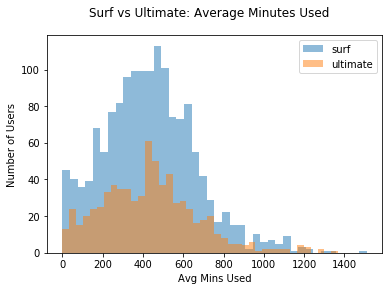

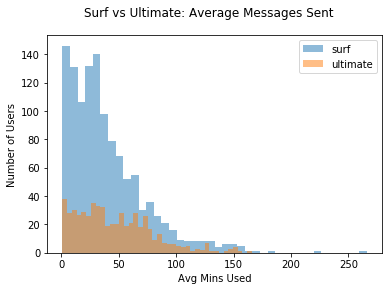

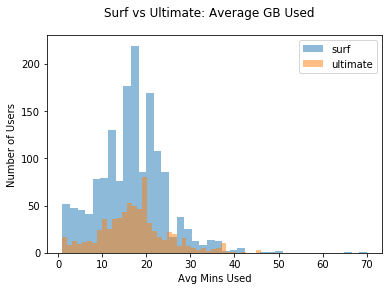

In [18]:
# Find the minutes, texts, and volume of data the users of each plan require per month.

#Calculate the mean, dispersion, and standard deviation. 
surfUsage = userUsage.query('plan == "surf"')
ultimateUsage = userUsage.query('plan == "ultimate"')

surfMinutesMean = surfUsage['minutes_used_per_month'].mean()
surfMinutesVariance = surfUsage['minutes_used_per_month'].var()
surfMinutesStd = surfUsage['minutes_used_per_month'].std()
ultimateMinutesMean = ultimateUsage['minutes_used_per_month'].mean()
ultimateMinutesVariance = ultimateUsage['minutes_used_per_month'].var()
ultimateMinutesStd = ultimateUsage['minutes_used_per_month'].std()
print('Surf Minutes Used: Mean = %d mins, Variance = %d mins, Std = %d'% (surfMinutesMean, surfMinutesVariance, surfMinutesStd))
print('Ultimate Minutes Used: Mean = %d mins, Variance = %d mins, Std = %d'% (ultimateMinutesMean, ultimateMinutesVariance, ultimateMinutesStd))

surfMessagesMean = surfUsage['messages_sent_per_month'].mean()
surfMessagesVariance = surfUsage['messages_sent_per_month'].var()
surfMessagesStd = surfUsage['messages_sent_per_month'].std()
ultimateMessagesMean = ultimateUsage['messages_sent_per_month'].mean()
ultimateMessagesVariance = ultimateUsage['messages_sent_per_month'].var()
ultimateMessagesStd = ultimateUsage['messages_sent_per_month'].std()
print('Surf Messages Used: Mean = %d msgs, Variance = %d msgs, Std = %d' % (surfMessagesMean, surfMessagesVariance, surfMessagesStd))
print('Ultimate Messages Used: Mean = %d msgs, Variance = %d msgs, Std = %d' % (ultimateMessagesMean, ultimateMessagesVariance, ultimateMessagesStd))

surfDataMean = surfUsage['gb_used_per_month'].mean()
surfDataVariance = surfUsage['gb_used_per_month'].var()
surfDataStd = surfUsage['gb_used_per_month'].std()
ultimateDataMean = ultimateUsage['gb_used_per_month'].mean()
ultimateDataVariance = ultimateUsage['gb_used_per_month'].var()
ultimateDataStd = ultimateUsage['gb_used_per_month'].std()
print('Surf Data Used: Mean = %dGB, Variance = %d GB, Std = %d' % (surfDataMean, surfDataVariance, surfDataStd))
print('Ultimate Data Used: Mean = %d GB, Variance = %d GB, Std = %d' % (ultimateDataMean, ultimateDataVariance, ultimateDataStd))

# Plot histograms
kwargs = dict(histtype='stepfilled', alpha=0.5, bins=40)

figMins = plt.figure()
axMins = figMins.add_subplot(1,1,1)
axMins.hist(surfUsage['minutes_used_per_month'], label='surf', **kwargs)
axMins.hist(ultimateUsage['minutes_used_per_month'], label='ultimate', **kwargs)
figMins.suptitle('Surf vs Ultimate: Average Minutes Used')
axMins.set_xlabel("Avg Mins Used")
axMins.set_ylabel("Number of Users")
axMins.legend()

figMes = plt.figure()
axMes = figMes.add_subplot(1,1,1)
axMes.hist(surfUsage['messages_sent_per_month'], label='surf', **kwargs)
axMes.hist(ultimateUsage['messages_sent_per_month'], label='ultimate', **kwargs)
figMes.suptitle('Surf vs Ultimate: Average Messages Sent')
axMes.set_xlabel("Avg Mins Used")
axMes.set_ylabel("Number of Users")
axMes.legend()

figInt = plt.figure()
axInt = figInt.add_subplot(1,1,1)
axInt.hist(surfUsage['gb_used_per_month'], label='surf', **kwargs)
axInt.hist(ultimateUsage['gb_used_per_month'], label='ultimate', **kwargs)
figInt.suptitle('Surf vs Ultimate: Average GB Used')
axInt.set_xlabel("Avg Mins Used")
axInt.set_ylabel("Number of Users")
axInt.legend()

To find the minutes, messages and GB the users of each plan require per month, I calculated the mean, dispersion (variance) and standard deviation for surf (minutes used, messages sent, GB used) and ultimate (minutes used, messages sent, GB used).

The x axis shows the number of minutes/messages/gigabytes, and the y axis shows the number of users who use that many minutes/messages/gigabytes a month.

<div class="alert alert-danger">
    <s>See comment above about using userUsage dataframe for analysis.</s>
</div>

Text(0, 0.5, 'Gb Used')

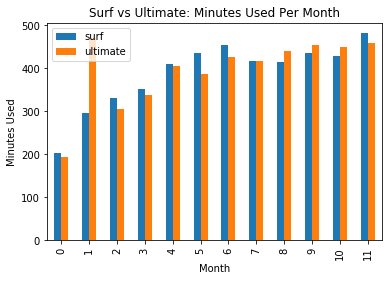

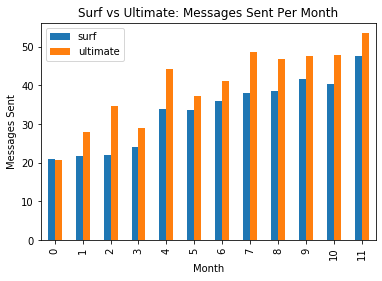

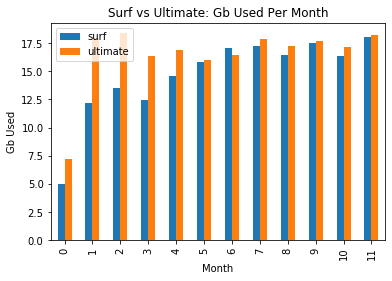

In [16]:
# not part of any steps

surfUsage = userUsage.query('plan == "surf"')
surfUsage = pd.pivot_table(surfUsage, values=['minutes_used_per_month','messages_sent_per_month','gb_used_per_month'], index=['call_month'], aggfunc=['mean'])
surfUsage.reset_index(inplace=True)
surfUsage.columns = ['month','surf_gb_used_per_month', 'surf_messages_sent_per_month','surf_minutes_used_per_month']
#display(surfUsage)

ultimateUsage = userUsage.query('plan == "ultimate"')
ultimateUsage = pd.pivot_table(ultimateUsage, values=['minutes_used_per_month','messages_sent_per_month','gb_used_per_month'], index=['call_month'], aggfunc=['mean'])
ultimateUsage.reset_index(inplace=True)
ultimateUsage.columns = ['month','ultimate_gb_used_per_month', 'ultimate_messages_sent_per_month','ultimate_minutes_used_per_month']
#display(ultimateUsage)

minutesData = pd.DataFrame({
    "surf":surfUsage['surf_minutes_used_per_month'],
    "ultimate":ultimateUsage['ultimate_minutes_used_per_month'],
    }, 
    index=[0,1,2,3,4,5,6,7,8,9,10,11]
)
minutesData.plot(kind="bar", title='Surf vs Ultimate: Minutes Used Per Month')
plt.xlabel("Month")
plt.ylabel("Minutes Used")

messagesData = pd.DataFrame({
    "surf":surfUsage['surf_messages_sent_per_month'],
    "ultimate":ultimateUsage['ultimate_messages_sent_per_month'],
    }, 
    index=[0,1,2,3,4,5,6,7,8,9,10,11]
)
messagesData.plot(kind="bar", title='Surf vs Ultimate: Messages Sent Per Month')
plt.xlabel("Month")
plt.ylabel("Messages Sent")

internetData = pd.DataFrame({
    "surf":surfUsage['surf_gb_used_per_month'],
    "ultimate":ultimateUsage['ultimate_gb_used_per_month'],
    }, 
    index=[0,1,2,3,4,5,6,7,8,9,10,11]
)
internetData.plot(kind="bar", title='Surf vs Ultimate: Gb Used Per Month')
plt.xlabel("Month")
plt.ylabel("Gb Used")


In [19]:
# Test the hypothesis: The average profit from users of Ultimate and Surf calling plans differs.

# filter outliers from monthly profit using zscore
z_scores = st.zscore(userUsage['month_profit'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
userUsage = userUsage[filtered_entries]

# query surf users
surfUsers = userUsage.query('plan == "surf"')
surfAverageProfit = surfUsers['month_profit'].mean().round(decimals=2)
print('The average monthly profit made from surf users is: $' + str(surfAverageProfit))

# query ultimate users
ultimateUsers = userUsage.query('plan == "ultimate"')
ultimateAverageProfit = ultimateUsers['month_profit'].mean().round(decimals=2)
print('The average monthly profit made from ultimate users is: $' + str(ultimateAverageProfit))

# perform a t-test
results = st.ttest_ind(surfUsers['month_profit'], ultimateUsers['month_profit'], equal_var=False)
p_value = results.pvalue
alpha = 0.5

if p_value < alpha:
    print('Reject H0')
else:
    print('Cannot reject H0')

The average monthly profit made from surf users is: $53.6
The average monthly profit made from ultimate users is: $72.34
Reject H0


We want to test the hypothesis that the average profit from users of ultimate and surf plans differ. We can do this using an independent samples t-test to compare the means from two groups (ultimate and surf users). We can apply a  t-test here  due to the Central Limit Theorem, which implies that you can estimate the mean of a statistical population using the mean of a sample, and since the means are approximately normally distributed,  we can use the t-test

Null Hypothesis H0: The average profit from users of Ultimate does not differ from the average profit from users of Surf.
Alternative Hypothesis H1: The average profit from users of Ultimate does differ from the average profit from users of Surf. 

The p_value tells us that we can reject the null hypothesis, thus indicating that the average profit of Ultimate users does differ from the average profit of Surf users. This can be further proven by looking at the numbers: The average monthly profit from ultimate users is 72.34 while the average monthly profit from surf users is 53.6.

In [16]:
# Test the hypothesis: The average profit from users in NY-NJ area is different from that of the users from other regions.

# get the subset of users in NY-NJ area
NYNJ = users[users['city'].str.contains('NY-NJ')]
users_nynj = NYNJ['user_id']
userUsageNYNJ = userUsage.query('user_id in @users_nynj')
avgProfitNYNJ = userUsageNYNJ['month_profit'].mean().round(decimals=2)
print('The average monthly profit made users in NY-NJ area is: $' + str(avgProfitNYNJ))

# get the subset of users not in NY-NJ area
notNYNJ= users[~users['city'].str.contains('NY-NJ')]
users_notnynj = notNYNJ['user_id']
userUsageNotNYNJ = userUsage.query('user_id in @users_notnynj')
avgProfitNotNYNJ = userUsageNotNYNJ['month_profit'].mean().round(decimals=2)
print('The average monthly profit made users NOT in NY-NJ area is: $' + str(avgProfitNotNYNJ))

results = st.ttest_ind(userUsageNYNJ['month_profit'], userUsageNotNYNJ['month_profit'], equal_var=False)
p_value = results.pvalue
alpha = 0.5

if p_value < alpha:
    print('Reject H0')
else:
    print('Cannot reject H0')

The average monthly profit made users in NY-NJ area is: $56.1
The average monthly profit made users NOT in NY-NJ area is: $60.22
Reject H0


We want to test the hypothesis that the average profit from users in NY-NJ area is different than that of users from other regions.  We can do this using an independent samples t-test to compare the means from two groups (NY-NJ and non NY-NJ users). We can apply a  t-test here  due to the Central Limit Theorem, which implies that you can estimate the mean of a statistical population using the mean of a sample, and since the means are approximately normally distributed,  we can use the t-test

Null Hypothesis H0: The average profit from users in NY-NJ does not differ from the average profit from users of other regions.
Alternative Hypothesis H1: The average profit from users in NY-NJ does differ from the average profit from users of other regions. 

The p_value tells us that we can reject the null hypothesis, thus indicating that the average profit of NY-NJ users does differ from the average profit of non NY-NJ users. This can be further proven by looking at the numbers: The average monthly profit from NY-NJ users is 56.10 while the average monthly profit from non NY-NJ users is 60.22.

Overall Conclusion:

I found that the difference between the profit made from Ultimate and Surf was statistically significant enough to conclude that the Ultimate plan is more profitable than the Surf plan and I recommend that the commercial department adjust the advertising budget such that the Ultimate plan receives more advertisements. 

The average monthly profit made from surf users is 53.6 while the avergae monthly profit made from Ultimate users if 72.34.